In [16]:
%matplotlib inline
import numpy as np
import math
import warnings
from skimage import io
from pylab import *
from matplotlib import pylab as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import imshow

warnings.simplefilter("ignore")

In [2]:
def bresenham(x1, y1, x2, y2):
    x = x1
    y = y1
    points = []
    if x1 < x2:
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2

    if y1 < y2:
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y1

    points.append([x,y])
    
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        while x != x2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                x += xi
                d += bi
            points.append([x,y])
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        while y != y2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                y += yi
                d += bi
            points.append([x,y])

    return points

In [3]:
def sum_points(points, img):
    sumOfPoints = 0
    for point in points:
        sumOfPoints += img[point[0],point[1]]
    return sumOfPoints

In [4]:
def coordToCart(angle, cx, cy, radius):
    x = int(math.cos(math.radians(angle)) * radius) + cx
    y = int(math.sin(math.radians(angle)) * radius) + cy
    return x,y

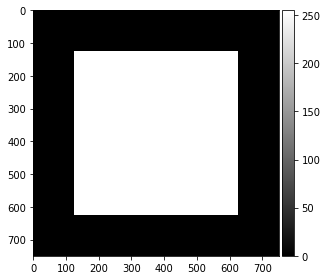

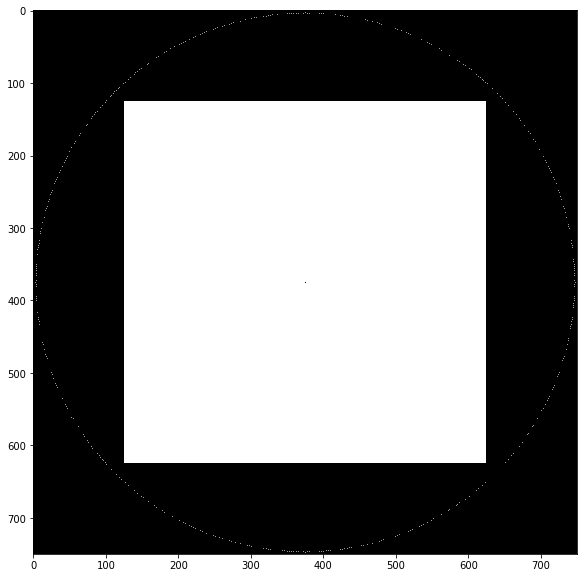

In [5]:
square_size = 500
square = np.zeros((square_size,square_size), dtype=np.float64)
#square[int(square_size/3):int(2*square_size/3), int(square_size/3):int(2*square_size/3)]=255
square[0:square_size,0:square_size] = 255

offset = int((int(square_size*1.5) - square_size)/2)
image = np.zeros((int(square_size*1.5),int(square_size*1.5)))
for i in range(square_size):
    for j in range(square_size):
        image[i+offset,j+offset]= square[i,j]
    

io.imshow(image, cmap='gray')

# Przyrost katów inc_angle emitera (położenie emitera), kąt z jakim wysyłane są fale (emiter_angle)
inc_angle, emiter_angle = 2, 15.0
beta = emiter_angle*2
centre = int(square_size*1.5/2)
detectors = 21
radius = centre-3

sinogram = np.zeros((int(360/inc_angle),detectors))
image[centre, centre] = 0

#petla - kazda pozycja emitera
for angle in range(0, 360, inc_angle):
    emiter_x, emiter_y = coordToCart(angle, centre, centre, radius)
    
   
    #petla - kazda pozycja detektora
    for a in range(detectors):
        alfa = angle + 180 - beta/2 + a*beta/(detectors-1)
        detx, dety = coordToCart(alfa, centre, centre, radius)
        image[detx,dety] = 155
        if dety < emiter_y:
            points = bresenham(detx, dety, emiter_x, emiter_y)
        else:
            points = bresenham(emiter_x, emiter_y, detx, dety)
        
        sinogram[int(angle/inc_angle),a] = sum_points(points, image)
        
#print(sinogram)
#print(square[0,0])
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(image, cmap='gray')
#ax.imshow(sinogram, cmap='gray')

In [38]:
def doTomography(img, emiterAngles, inc_angle, emiterRange=60.0, detectors=200):
    # Przyrost katów inc_angle emitera (położenie emitera), kąt z jakim wysyłane są fale (emiter_angle)
    beta = emiterRange*2
    emiters = img.copy()
    img_size = img.shape[0]
    centre = int(img_size/2)
    radius = centre-5
    sinogram = np.zeros((len(emiterAngles),detectors))

    #petla - kazda pozycja emitera
    for angle in emiterAngles:
        emiter_x, emiter_y = coordToCart(angle, centre, centre, radius)
        emiters[emiter_y, emiter_x] = 255
    
        #petla - kazda pozycja detektora
        for a in range(detectors):
            alfa = angle + 180 - beta/2 + a*beta/(detectors-1)
            detx, dety = coordToCart(alfa, centre, centre, radius)
            
            if dety < emiter_y:
                points = bresenham(detx, dety, emiter_x, emiter_y)
            else:
                points = bresenham(emiter_x, emiter_y, detx, dety)
                
            sinogram[int(angle/inc_angle),a] = sum_points(points, img)
            
    return emiters, sinogram



def createOffset(img, offset=2):
    square_size = img.shape[0]
    side = int((int(square_size*offset) - square_size)/2)
    image = np.zeros((int(square_size*offset),int(square_size*offset)))
    for i in range(square_size):
        for j in range(square_size):
            image[i+side,j+side]= img[i,j]
    return image

def delOffset(img, offset=2):
    img_size = img.shape[0]
    new_size = int((img_size/offset))
    side = int((img_size-new_size)/2)
    image = np.zeros((new_size,new_size))
    image[:,:] = img[side:side+new_size, side:side+new_size]
    return image 

def createSquare(square_size=500):
    square = 255*np.ones((square_size,square_size), dtype=np.float64)
    return square

In [67]:

def doInvTomography(sinogram, img_size, emiterAngles, inc_angle, emiterRange=60.0, detectors=200):
    # Przyrost katów inc_angle emitera (położenie emitera), kąt z jakim wysyłane są fale (emiter_angle)
    beta = emiterRange*2
    centre = int(img_size/2)
    radius = centre-5
    #print(sinogram)
    img = np.zeros((img_size, img_size))

    #petla - kazda pozycja emitera
    for angle in emiterAngles:
        emiter_x, emiter_y = coordToCart(angle, centre, centre, radius)
        

        #petla - kazda pozycja detektora
        for a in range(detectors):
            alfa = angle + 180 - beta/2 + a*beta/(detectors-1)
            detx, dety = coordToCart(alfa, centre, centre, radius)
            #image[detx,dety] = 155
            if dety < emiter_y:
                points = bresenham(detx, dety, emiter_x, emiter_y)
            else:
                points = bresenham(emiter_x, emiter_y, detx, dety)

            for point in points:
                img[point[0], point[1]] += int(sinogram[int(angle/inc_angle), a])

    return img

def main(file='square', square_size=500, offset=2, inc_angle=1, emiterRange=60.0, detectors=200):
    if file != 'square':
        img = mpimg.imread(file)
    else:
        img = createSquare(square_size)
    
    #obrazek wyjsciowy z offsetem
    fig = figure(figsize=(40,20))
    imgWithOffset = createOffset(img, offset)
    subplot(4,1,1)
    imshow(imgWithOffset, cmap='gray')
    imgSize = imgWithOffset.shape[0]
    
    #sinogram
    emiterAngles = np.linspace(0, 360, 360/inc_angle, endpoint=False)
    emiters, sinogram = doTomography(imgWithOffset, emiterAngles, inc_angle, emiterRange, detectors)
    subplot(4,1,2)
    imshow(sinogram, cmap='gray')
    
    
    #obrazem z sinogramu
    imgFromSinogram = doInvTomography(sinogram, imgSize, emiterAngles, inc_angle, emiterRange, detectors)
    subplot(4,1,3)
    imshow(imgFromSinogram, cmap='gray')
    
    #subplot(4,1,4)
    #imshow(emiters, cmap='gray')
    
    imgToCompare = delOffset(imgFromSinogram, offset)
    subplot(4,1,4)
    imshow(imgToCompare, cmap='gray')
    #print(img[40:60,40:60],imgToCompare[40:60,40:60])

[[255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255

AttributeError: 'NoneType' object has no attribute 'conjugate'

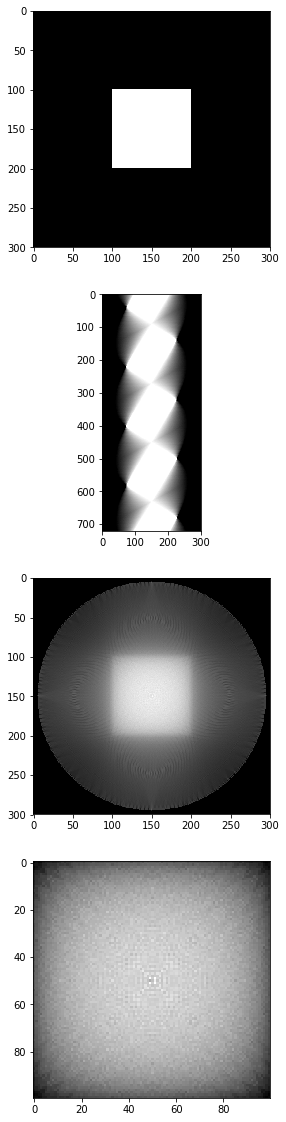

In [71]:
img = main(square_size=100, offset=3, emiterRange=80.0, inc_angle=0.5, detectors=300)

NameError: name 'imgToCompare' is not defined